$R_n - G_s = LE + H$
    

$R_n = (1 - \alpha_s) R_{si} + R_{il} - \epsilon_s \sigma T_s^4$

net solar radiation

$R_{il}  - \sigma T_a^4$

$\alpha_s$ depends on soil moisture

$\epsilon_s$ also depends on soil moisture (funcional form)

- BC = state, not constant flux
- what do we think about discontinuities at the transition??

In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import numpy as np

for mod in ["sutton_functions"]:
    if mod in sys.modules:
            del sys.modules[mod]
            
from sutton_functions import *

CPU times: user 1.62 s, sys: 992 ms, total: 2.61 s
Wall time: 480 ms


In [2]:
def get_params(fallow_fraction = 0.5, fallow_length = 1000, 
               T_sc = 28, T_sf = 50, T_a = 18, 
               RH_c = 43, RH_f = 20, 
               h = 2.3, zom_f = 0.005,
               zom_c = 0.05,  SW_in = 400, 
               e_f = 0.95, e_c = 0.95, e_a = .8, 
               alpha_c = 0.22, alpha_f = 0.22, RH_a = 18,
               verbose = False, lm_option = 'kz', 
              ):
    
    # Flat parameter dictionary
    params = {
        "k": 0.4,                # von Karman constant        
        "zom_f": zom_f,          # Momentum roughness length (m), fallow
        "zom_c": zom_c,          # Momentum roughness length (m), cultivated

        'h' : h,
        "Lx": 2000,           # Domain length in x-direction
        "Hmax": 100,          # Maximum height
        "fallow_fraction": fallow_fraction,
        "fallow_length" : fallow_length,
        "dz": 0.5,
        "dx": 5,
        
        'RH_c' : RH_c,
        'RH_f' : RH_f,
        'RH_a' : RH_a,        
        'T_sc' : T_sc,  # Cultivated temperature
        'T_sf' : T_sf,  # Fallow temperature
        
        'SW_in' : SW_in,
        'T_a' : T_a,  # Atmos temperature
        'e_a' : e_a,
        
        'e_f' : e_f,
        'e_c' : e_c,
        'alpha_c' : alpha_c,
        'alpha_f' : alpha_f,
        'lm_option' : lm_option,

    }
    Ubar_4 = 3.76
    z_4 = 4
    ustar_f = 0.4*Ubar_4/np.log(z_4/zom_f)    # Friction velocity (m/s)
    ustar_c = 0.4*Ubar_4/np.log(z_4/zom_c)

    params['xmin'] = 0
    params['ustar_f'] = ustar_f
    
    params['xmax'] = params['Lx']
    params['zmin'] = params['zom_f']
    params['zmax'] = params['Hmax']
    params['fallow_size'] = int(params['fallow_length']/params['dx']) 
    
    if fallow_fraction > 0:
        params['field_size'] = int(params['fallow_size']*(1- fallow_fraction)/fallow_fraction)
    else:
        params['field_size'] = 0
        
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
    nz = len(z)
    x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
    nx = len(x)   
    
    es_c = saturation_vapor_pressure(T_sc + 273.15)
    Q_c = vapor_concentration_RH(T_sc, RH_c)

    es_f = saturation_vapor_pressure(T_sf + 273.15)
    Q_f  = vapor_concentration_RH(T_sf, RH_f)
    Q_a  = vapor_concentration_RH(T_a, RH_a)

    if verbose:
        print(f"Cultivated \nSaturation vapor pressure at T={T_sc}°C, RH={RH_c}% is {es_c:.2f} Pa")
        print(f"Water vapor concentration is {Q_c:.2f} g/m³")

        print(f"Fallow \nSaturation vapor pressure at T={T_sf}°C, RH={RH_f}% is {es_f:.2f} Pa")
        print(f"Water vapor concentration is {Q_f:.2f} g/m³")

    params['Q_c'] =  Q_c   # Surface water vapor concentration for cultivated areas
    params['Q_f'] =  Q_f   # Surface water vapor concentration for fallowed areas        
    params['Q_a'] =  Q_a   # Upwind background atmospheric water vapor concentration, fallow areas
    params['nx'] = nx
    params['nz'] =  nz 
         
    return params

def populate_Qc_array(params):
    """
    Retrieve parameters from the dictionary
    """
    x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
    nx = len(x)

    fallow_size = params["fallow_size"]
    field_size = params["field_size"]
    Q_c = params["Q_c"]
    Q_f = params["Q_f"]
    
    # Initialize the array with zeros or any other default value
    Q_c_array = x*0
    
    # Populate the array with alternating patches
    i = 0
   
    while i <= nx :
        # Assign a vegetated patch of fixed length
        Q_c_array[i:i + fallow_size] = Q_c 
        i += fallow_size
        
        # Assign a fallow patch of fixed length, if within bounds
        if i < nx :
            Q_c_array[i:i + field_size+1] = Q_f 
            i += field_size+1
            
    return np.array(Q_c_array)

In [3]:
p = Params(fallow_length=1000, fallow_fraction =0.5, T_sc=28)
print(p)              # nice readable repr
d = p.to_dict()       # dict view, like your old params
(d["ustar_f"], d['ustar_c'])   # derived value


Params(k=0.4, zom_f=0.005, zom_c=0.05, h=2.3, Lx=2000.0, Hmax=100.0, dz=0.5, dx=5.0, xmin=0.0, fallow_fraction=0.5, fallow_length=1000, T_sc=28, T_sf=50.0, T_a=18.0, RH_c=43.0, RH_f=20.0, RH_a=18.0, SW_in=400.0, e_f=0.95, e_c=0.95, e_a=0.8, alpha_c=0.22, alpha_f=0.22, lm_option='kz')


(0.22499436934756767, 0.3432201867736777)

In [4]:
def dict_diff_shallow(a, b):
    a_keys, b_keys = set(a), set(b)
    added   = {k: b[k] for k in b_keys - a_keys}
    removed = {k: a[k] for k in a_keys - b_keys}
    changed = {k: (a[k], b[k]) for k in a_keys & b_keys if a[k] != b[k]}
    same    = {k: a[k] for k in a_keys & b_keys if a[k] == b[k]}
    return {"added": added, "removed": removed, "changed": changed, "same": same}

# dict_diff_shallow(dd, d)['added'];

In [5]:
def get_lm(k,h,z, option = 'kz'):
    """
    mixing length option
    
    lm = k * (z - d)   
    lm[z < h] = k*h/3
    
    """
    if option == 'kz':
        lm = k*z
    else:
        lm = k*(z - d)    
        lm[z < h] = k*h/3    
    return lm

In [6]:
def uniform_Q(params):
    """
    The function computes an implicit solution for water vapor concentration and
    flux in a turbulent boundary layer.
    
    - Uses an implicit finite-difference method for solving the transport equation.
    - Implements mixing length theory to define eddy diffusivity.
    - Marches along the x-direction to iteratively solve for the concentration field.

    """
    nx = params['nx']
    nz = params['nz']    
    dx = params['dx']    
    dz = params['dz']  
    zmax = params['zmax']      
    k = params['k']            
    ustar = params['ustar_f']
    zom = params['zom_f']  
    zoh = params['zom_f']/5      
    Q_f = params['Q_f']
    Q_c = params['Q_c']
    Q_a = params['Q_a']
    h = params['h']
    lm_option = params['lm_option']

    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])    
    
    LE_f = ustar*k*(Q_f - Q_a)/np.log(zmax/zoh)
    Qup = Q_f - LE_f/(k*ustar)*np.log(z/zoh)
    
    LE_c = ustar*k*(Q_c - Q_a)/np.log(zmax/zoh)
    Qdown = Q_c - LE_c/(k*ustar)*np.log(z/zoh)    
    
    U = (ustar / k) * np.log(z / zom)
    
    zc = z.copy()
    zc[0] = dz / np.log(z[1]/z[0])
    for i in range(1, nz-1):
        zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
    zc[-1] = dz / np.log(z[-1]/z[-2])
        
    d = 2/3*h
    lm = get_lm(k,h, z, lm_option)    
    
    # Setup coefficients for the implicit scheme
    A = lm * ustar
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    Q1 = Qup
    Q_uniform = np.zeros((nx , nz))
    Q_uniform[0, :] = Q1
    FluxQ_uniform = np.zeros((nx , nz))

    # Begin downwind calculations by marching along x
    for i in range(nx):
        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Qdown[0], Q_a)
   
        Q_uniform[i, :] = Q2
        FluxQ_uniform[i, :] = Fq
        Q1 = Q2

    return Q_uniform, FluxQ_uniform


def varying_Qs(params):
    
    nx = params['nx']
    nz = params['nz']    
    dx = params['dx']        
    dz = params['dz']        
    k = params['k']            
    ustar = params['ustar_f']
    zom = params['zom_f']  
    zmax = params['zmax']  
    zoh = params['zom_f']/5      
    
    Q_c = params['Q_c']
    Q_f = params['Q_f']
    Q_a = params['Q_a']
    h = params['h']
    lm_option = params['lm_option']
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])    
    
    LE_f = ustar*k*(Q_f - Q_a)/np.log(zmax/zoh)
    Qup = Q_f - LE_f/(k*ustar)*np.log(z/zoh)
    
    LE_c = ustar*k*(Q_c - Q_a)/np.log(zmax/zoh)
    Qdown = Q_c - LE_c/(k*ustar)*np.log(z/zoh)    
    
    U = (ustar / k) * np.log(z / zom)
    
    Qs_array = populate_Qc_array(params)    
    
    zc = z.copy()
    zc[0] = dz / np.log(z[1]/z[0])
    for i in range(1, nz-1):
        zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
    zc[-1] = dz / np.log(z[-1]/z[-2])
    
    # Setup coefficients for the implicit scheme
    zom = h/10
    d = 2/3*h
    
    # Setup coefficients for the implicit scheme
    lm = get_lm(k,h, z, lm_option)    
    A = lm * ustar
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Initialize upwind water vapor concentrations and fluxes
    Q1 = Qup
    Q = np.zeros((nx, nz))
    Q[0, :] = Q1
    FluxQ = np.zeros((nx, nz))

    # Perform downwind calculations by marching along x
    for i, Qs_i in enumerate(Qs_array):

        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Qs_i, Q_a)
        Q[i, :] = Q2
        FluxQ[i, :] = Fq
        Q1 = Q2

        
    return Q, FluxQ

def uniform_T(params):
    """
    The function solves an implicit equation for temperature transport in a turbulent boundary layer.
    
    - Uses an implicit finite-difference method to solve the advection-diffusion equation.
    - Mixing length theory is applied to define eddy diffusivity.
    - Marches along the x-direction to iteratively compute the temperature field.
    
    """
    
    nx = params['nx']
    nz = params['nz']    
    dx = params['dx']        
    dz = params['dz']        
    k = params['k']            
    ustar = params['ustar_f']
    zom = params['zom_f']  
    zoh = params['zom_f']/5      
    zmax = params['zmax']
    
    T_sf = params['T_sf']    
    T_sc = params['T_sc']
    T_a = params['T_a']
    h = params['h']    
    lm_option = params['lm_option']

    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])  
    
    wT = -(T_a - T_sf)*k*ustar/np.log(zmax/zoh) # K m/s
    
    Tup = T_sf - wT/(k*ustar)*np.log(z/zoh)

    wT_down = -(T_a - T_sc)*k*ustar/np.log(zmax/zoh) # K m/s
    
    Tdown = T_sc - wT_down/(k*ustar)*np.log(z/zoh)

    U = (ustar / k) * np.log(z / zom)    

    zc = z.copy()    
    zc[0] = dz / np.log(z[1]/z[0])
    for i in range(1, nz-1):
        zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
    zc[-1] = dz / np.log(z[-1]/z[-2])
    
    d = 2/3*h
    
    # Setup coefficients for the implicit scheme
    lm = get_lm(k,h, z, lm_option)       
    A = lm * ustar
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    T1 = Tup
    T_uniform = np.zeros((nx , nz))
    T_uniform[0, :] = T1
    FluxT_uniform = np.zeros((nx , nz))

    # Begin downwind calculations by marching along x
    for i in range(nx):
        T2, FT = integrate_T_implicit(nx, nz, dx, dz, A, B, C, T1, Tdown[0], T_a)
        T_uniform[i, :] = T2
        FluxT_uniform[i, :] = FT
        T1 = T2
    
    return T_uniform, FluxT_uniform


In [7]:

def adjust_T_sf(params, level = 5):
    
    ustar = params['ustar_f']
    k = params['k']
    Hmax = params['Hmax']
    zom = params['zom_f']
    zoh = params['zom_f']/5

    Q_a = params['Q_a']
    Q_f = params['Q_f']
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])
    dz = params['dz']
    dx = params['dx']

    nx = params['nx']
    nz = params['nz']
    zmax = params['zmax']
    
    T_a = params['T_a']
    T_sf = params['T_sf']
    
    e_a = params['e_a']
    e_f = params['e_f']
    
    SW_in = params['SW_in']
    alpha_f = params['alpha_f']
    lm_option = params['lm_option']
    
    # upwind LE 
    LE_f = ustar*k*(Q_f - Q_a)/np.log(Hmax/zoh)

    # Specify upwind wv concentration (as background)
    Qup = Q_f - LE_f/(k*ustar)*np.log(z/zoh)
        
    # Generate the mean velocity profile from the log-law
    U = (ustar / k) * np.log(z / zom)

    wT = - (T_a - T_sf)*k*ustar/np.log(zmax/zoh) # K m/s
    Tup = T_sf - wT/(k*ustar)*np.log(z/zoh)
    
    dTdz = our_central_difference(Tup, dz)
    dQdz = our_central_difference(Qup, dz)
    
    h = params['h']
    zom = h/10
    d = 2/3*h
      
    lm = get_lm(k,h, z, lm_option)       

    A = lm * ustar
       
    FT = np.zeros_like(Tup)    
    FT[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dTdz[:-1] + dTdz[1:]) * 0.5

    FT[1] = FT[2]
    FT[0] = FT[1]   

    Fq = np.zeros_like(Qup)    
    Fq[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dQdz[:-1] + dQdz[1:]) * 0.5

    Fq[1] = Fq[2]
    Fq[0] = Fq[1]   
    
    sigma_sb = 5.67*1e-8
    
    LW_out_f = e_f*sigma_sb*(Tup[level]+273.15)**4
    LW_in_f = e_a*sigma_sb*(Tup[-1]+273.15)**4

    Rn_f = (1 - alpha_f)*SW_in  + LW_in_f - LW_out_f

    SH_f = FT[level]*1005*1.2
    LH_f = Fq[level]*2260 
    
    error_f = Rn_f - SH_f - LH_f
    
    return error_f, Rn_f, SH_f, LH_f

def get_T_sf(SW_in = 400, T_a = 16, T_sf = 40, alpha_f = 0.2, alpha_c = 0.2,  RH_a = 20):
    
    params = get_params(T_sc = 30, T_sf = T_sf , T_a = T_a, SW_in = SW_in, 
            alpha_f = alpha_f, RH_a = RH_a)

    error_f, Rn_f, SH_f, LH_f = adjust_T_sf(params)

    while error_f < 0:
        
        T_sf -= 0.5
        params = get_params(T_sc = 30, T_sf = T_sf, T_a = T_a, SW_in = SW_in, 
                alpha_f = alpha_f, RH_a = RH_a)
        
        error_f, Rn_f, SH_f, LH_f = adjust_T_sf(params)

    while error_f > 0.1:
        
        T_sf += .01
        params = get_params(T_sc = 30, T_sf = T_sf, T_a = T_a, SW_in = SW_in, 
                alpha_f = alpha_f, RH_a = RH_a)
        
        error_f, Rn_f, SH_f, LH_f = adjust_T_sf(params)

    return T_sf, Rn_f, SH_f, LH_f, params


def adjust_T_sc(params, level = 0):
    
    ustar = params['ustar_f']
    k = params['k']
    zmax = params['zmax']
    zom = params['zom_f']
    zoh = params['zom_f']/5

    Q_a = params['Q_a']
    Q_c = params['Q_c']
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])
    dz = params['dz']
    dx = params['dx']

    nx = params['nx']
    nz = params['nz']
    zmax = params['zmax']
    
    T_a = params['T_a']
    T_sc = params['T_sc']

    e_a = params['e_a'] 
    e_c = params['e_c']     
 
    SW_in = params['SW_in']
    alpha_c = params['alpha_c']
    
    lm_option = params['lm_option']

    
    LE_c = ustar*k*(Q_c - Q_a)/np.log(zmax/zoh)

    # Specify upwind wv concentration (as background)
    Qdown = Q_c - LE_c/(k*ustar)*np.log(z/zoh)
    
    # Generate the mean velocity profile from the log-law
    U = (ustar / k) * np.log(z / zom)

    wT = -( T_a - T_sc)*k*ustar/np.log(zmax/zoh) # K m/s
    Tdown = T_sc - wT/(k*ustar)*np.log(z/zoh)

    dTdz = our_central_difference(Tdown, dz)
    dQdz = our_central_difference(Qdown, dz)

    h = params['h']
    zom = h/10
    d = 2/3*h
    
    lm = get_lm(k,h, z, lm_option)  


    A = lm * ustar

    FT = np.zeros_like(Tdown)    
    FT[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dTdz[:-1] + dTdz[1:]) * 0.5

    FT[1] = FT[2]
    FT[0] = FT[1]   

    Fq = np.zeros_like(Qdown)    
    Fq[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dQdz[:-1] + dQdz[1:]) * 0.5

    Fq[1] = Fq[2]
    Fq[0] = Fq[1]   
       
    sigma_sb = 5.67*1e-8
    
    LW_out_c = e_c*sigma_sb*(Tdown[level] + 273.15)**4
    LW_in_c = e_a*sigma_sb*(T_a + 273.15)**4

    Rn_c = (1 - alpha_c)*SW_in + LW_in_c - LW_out_c

    SH_c = FT[level]*1005*1.2
    LH_c = Fq[level]*2260

    error_c = Rn_c - SH_c - LH_c
    
    return error_c, Rn_c, SH_c, LH_c, Tdown, Qdown


def get_T_sc(SW_in = 400, T_a = 18, T_sf = 50, T_sc = 24, alpha_c = 0.2, 
             alpha_f = 0.2, RH_a = 20):
    
    params = get_params(T_sc = T_sc, T_sf = T_sf, T_a = T_a, SW_in = SW_in, 
                        alpha_c = alpha_c,  RH_a = RH_a)
    
    error_c, Rn_c, SH_c, LH_c, Tdown, Qdown  = adjust_T_sc(params)

    
    while error_c < 0:
        T_sc -= 0.5
        params = get_params(T_sc = T_sc, T_sf = T_sf,  T_a = T_a, SW_in = SW_in, 
                        alpha_c = alpha_c,  RH_a = RH_a)
        
        error_c, Rn_c,  SH_c, LH_c, Tdown, Qdown = adjust_T_sc(params)

    while error_c > 0.1:
        
        T_sc += .05
        params = get_params(T_sc = T_sc,  T_sf = T_sf,  T_a = T_a, SW_in = SW_in, 
                        alpha_c = alpha_c,  RH_a = RH_a)
        
        error_c, Rn_c, SH_c, LH_c, Tdown, Qdown = adjust_T_sc(params)
        
    return T_sc, Rn_c, SH_c, LH_c, params

In [8]:
sigma_sb = 5.67*1e-8
alpha_c = 0.2
alpha_f = 0.2
SW_in = 400
T_a = 20
RH_a = 20
T_sf = 30

params = get_params(T_sc = 30, T_sf = T_sf , T_a = T_a, SW_in = SW_in, alpha_f = alpha_f,
                    alpha_c = alpha_c, RH_a = RH_a)
error_f, Rn_f, SH_f, LH_f = adjust_T_sf(params)


In [9]:
T_sf, Rn_f, SH_f, LH_f, params = get_T_sf(T_a = T_a, SW_in = SW_in, 
                            alpha_f = alpha_f, alpha_c = alpha_c, RH_a = RH_a)
error_f, Rn_f,  SH_f, LH_f  = adjust_T_sf(params)

f"error = {error_f:.2f}W/m2, Rn_f={Rn_f:.0f}, SH_f={SH_f:.0f}, LH_f = {LH_f:.0f}, T_sf={T_sf:.2f}"

'error = 0.06W/m2, Rn_f=210, SH_f=119, LH_f = 91, T_sf=47.31'

In [10]:
T_sc, Rn_c, SH_c, LH_c, params = get_T_sc(T_a = T_a, T_sf = T_sf, SW_in = SW_in, 
                              alpha_f = alpha_f, alpha_c = alpha_c, RH_a = RH_a)
error_c, Rn_c, SH_c, LH_c, Tdown, Qdown  = adjust_T_sc(params)

f"error = {error_c:.2f}W/m2, Rn_c={Rn_c:.0f}, SH_c={SH_c:.0f}, LH_c = {LH_c:.1f}, T_sc={T_sc:.2f}"

'error = -0.32W/m2, Rn_c=208, SH_c=77, LH_c = 131.7, T_sc=38.80'

In [11]:
def get_upwind_fluxQ(params):
    """
    """
    ustar = params['ustar_f']    
    dz = params['dz']
    nz = params['nz']
    k = params['k']
    zmax = params['zmax']
    zoh = params['zom_f']/5
    h = params['h']
    nx = params['nx']     
    lm_option = params['lm_option']

    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])    
    zc = z.copy()

    zc[0] = dz / np.log(z[1]/z[0])
    for i in range(1, nz-1):
        zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
    zc[-1] = dz / np.log(z[-1]/z[-2])
    
    k = params['k']
    Q_f = params['Q_f']
    Q_a = params['Q_a']
    
    LE_f = ustar*k*(Q_f - Q_a)/np.log(zmax/zoh)
    Qup = Q_f - LE_f/(k*ustar)*np.log(z/zoh)
    dQdz = our_central_difference(Qup, dz)

    d = 2/3*params['h']

    lm = get_lm(k,h, z, lm_option)
    
    A = lm * ustar
    
    FluxQ_upwind = np.zeros_like(Qup)    
    FluxQ_upwind[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dQdz[:-1] + dQdz[1:]) * 0.5

    FluxQ_upwind[1] = FluxQ_upwind[2]
    FluxQ_upwind[0] = FluxQ_upwind[1]   
    
    
    return Qup, FluxQ_upwind

def get_upwind_fluxT(params):
    """
    """
    dz = params['dz']
    nz = params['nz']
    nx = params['nx']    
    ustar = params['ustar_f']
    zmax = params['zmax']
    zoh = params['zom_f']/5
    h = params['h']
    lm_option = params['lm_option']    

    
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])    
    zc = z.copy()

    zc[0] = dz / np.log(z[1]/z[0])
    for i in range(1, nz-1):
        zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
    zc[-1] = dz / np.log(z[-1]/z[-2])
    
    k = params['k']
    T_sf = params['T_sf']
    T_a = params['T_a']
    Q_a = params['Q_a']        
    
    wT = -(T_a - T_sf)*k*ustar/np.log(zmax/zoh) # K m/s
    Tup = T_sf - wT/(k*ustar)*np.log(z/zoh)
    
    
    dTdz = our_central_difference(Tup, dz)

    d = 2/3*params['h']

    ustar = params['ustar_f']
    k = params['k']

    lm = get_lm(k,h, z, lm_option)    
    A = lm * ustar

    FluxT_upwind = np.zeros_like(Tup)    
    FluxT_upwind[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dTdz[:-1] + dTdz[1:]) * 0.5

    FluxT_upwind[1] = FluxT_upwind[2]
    FluxT_upwind[0] = FluxT_upwind[1]   

        
    return Tup, FluxT_upwind

Qup, FluxQ_upwind = get_upwind_fluxQ(params)
Tup, FluxT_upwind = get_upwind_fluxT(params)



In [12]:
T_uniform, FluxT_uniform = uniform_T(params)
Q_uniform, FluxQ_uniform = uniform_Q(params)

SH = FluxT_uniform*1005*1.2
LE = FluxQ_uniform*2.260*1e6/1000
FluxTotal = SH + LE


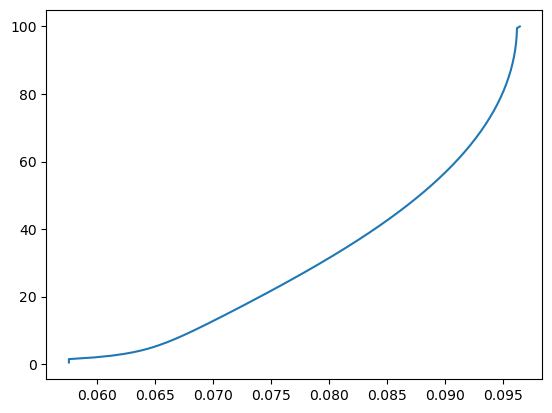

In [44]:
plt.plot( FluxT_uniform[-1],z)

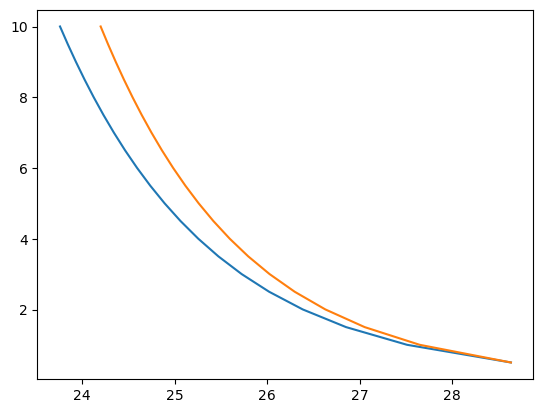

In [35]:
z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
plt.plot(Tdown[:20], z[:20])
plt.plot(T_uniform[-1][:20], z[:20])

196.73954379541524


210.4283271769165

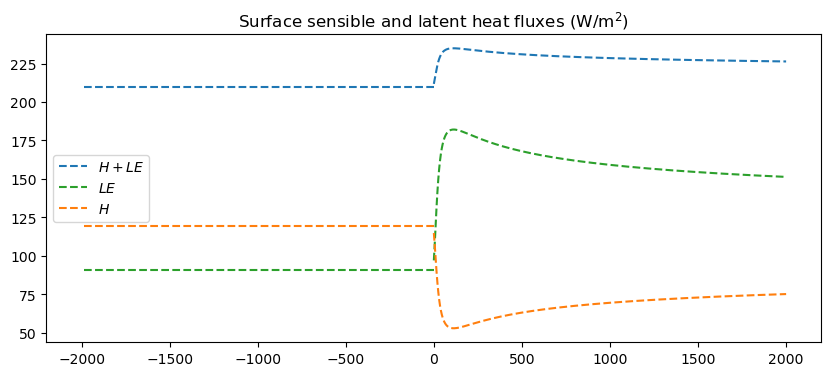

In [14]:
level = 5
plt.figure(figsize = (10, 4 ))
ax = plt.gca()

x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

ax.plot(x, FluxTotal[:, level],  c =  'C0', ls = '--', label = '$H + LE$')

FluxTotal_upwind = FluxQ_upwind[level]*np.ones_like(x)*2.260*1e6/1000 + \
            FluxT_upwind[level]*np.ones_like(x)*1005*1.2

ax.plot(-x, FluxTotal_upwind, ls = '--', c =  'C0')
ax.plot(x, FluxQ_uniform[:, level]*2.260*1e6/1000, ls = '--', c =  'C2')
ax.plot(-x, FluxQ_upwind[level]*np.ones_like(x)*2.260*1e6/1000,  ls = '--',
        c =  'C2',  label = "$LE$")

ax.plot(-x, FluxT_upwind[level]*np.ones_like(x)*1005*1.2, ls = '--', c =  'C1')
ax.plot(x[:], FluxT_uniform[:, level]*1005*1.2, c =  'C1', ls = '--', label = "$H$")
ax.legend()

ax.set_title("Surface sensible and latent heat fluxes (W/m$^2$)")

level = 0
print (FluxQ_upwind[level]*2.260*1e6/1000 + \
            FluxT_upwind[level]*1005*1.2)
FluxTotal[-1, level]


In [15]:

def ET_enhance(FluxQ_uniform, FluxQ_fallow, FluxQ, params):
    
    dx = params['dx']
    nx = params['nx']    
    Q_c = params['Q_c']
    Q_f = params['Q_f']    
    Qs_array = populate_Qc_array(params)
    continuous_cultivation = FluxQ_uniform[nx-1, 0]*dx
    
    uniform_flux = FluxQ_uniform[nx-1, level]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, level]*(Qs_array == Q_f).mean()
    uniform_flux = uniform_flux*dx
    
    FluxQ_force = FluxQ.copy()
    FluxQ_force[Qs_array < Q_c] = FluxQ_fallow[-1,level]
    
    return  continuous_cultivation, uniform_flux, FluxQ_force[:, level].mean()*dx


In [16]:
Qs_array = populate_Qc_array(params)

ustar = params['ustar_f']
dz = params['dz']
Q, FluxQ = varying_Qs(params)
Q_fallow, FluxQ_fallow = uniform_Q(params)
    
continuous_cultivation, uniform_flux, patchy_flux = ET_enhance(
    FluxQ_uniform, FluxQ_fallow, FluxQ, params)    

FluxQ_neg = FluxQ.copy()
FluxQ[Qs_array < params['Q_c']] = FluxQ_fallow[-1, level]

z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

QQ = np.sum(Q - params['Q_a'], axis=1) * dz
QQ_uniform = np.sum(Q_uniform - params['Q_a'], axis=1) * dz

print(patchy_flux/continuous_cultivation, patchy_flux/uniform_flux)

1.0000000000000002 2.0050000000000003


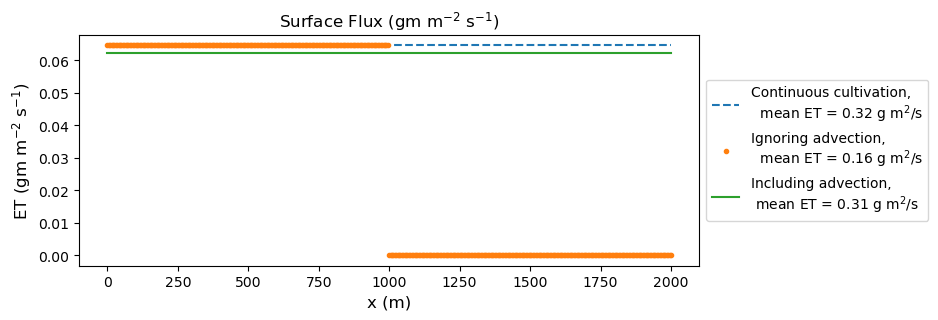

In [17]:
dz = params['dz']
dx = params['dx']

nx = params['nx']
nz = params['nz']

Q_a = params['Q_a']
Q_c = params['Q_c']
Q_f = params['Q_f']

plt.figure(figsize = (8, 3))
ax = plt.gca()

plt.plot(x, np.ones(nx ) * FluxQ_uniform[nx-1, 3], '--',  
         label = "Continuous cultivation, \n  mean ET = {0:.2f} g m$^2$/s".format(
             FluxQ_uniform[nx-1, 3]*dx))

uniform_flux = FluxQ_uniform[nx-1, 3]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, 3]*(Qs_array == Q_f).mean()
plt.plot(x, FluxQ_uniform[nx-1, 3]*(Qs_array > Q_f) + FluxQ_fallow[nx-1, 3]*(Qs_array == Q_f), '.', 
         label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format(
    uniform_flux*dx))

# FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,3]
plt.plot(x[:], FluxQ[:, 3], '-', label = "Including advection,  \n mean ET = {0:.2f} g m$^2$/s".format(
    FluxQ[:, 3].mean()*dx))

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# (FluxQ[:, 3].sum()*dx/nx - FluxQ[nx:,  3].sum()*dx)/(FluxQ[nx:,  3].sum()*dx)

# Plot excess water vapor and surface flux
plt.figure(figsize = (8, 6))
plt.subplot(2, 1, 1)
plt.plot(x, QQ, '-', label = 'Fallow patches')
plt.plot(x, QQ_uniform, '--', label = 'Uniform cultivated')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel(r'$\int [q(x,z) - q_a]dz$', fontsize=12, fontweight='normal')
plt.title('Excess water vapor (gm m$^{-2}$)', fontsize=12)


plt.subplot(2, 1, 2)
plt.plot(x[1:], FluxQ[1:, 3], '.-')
plt.plot(x[1:],  FluxQ_uniform[1:, 3], '--')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()
plt.axhline(0.25)
# plt.ylim(0, )

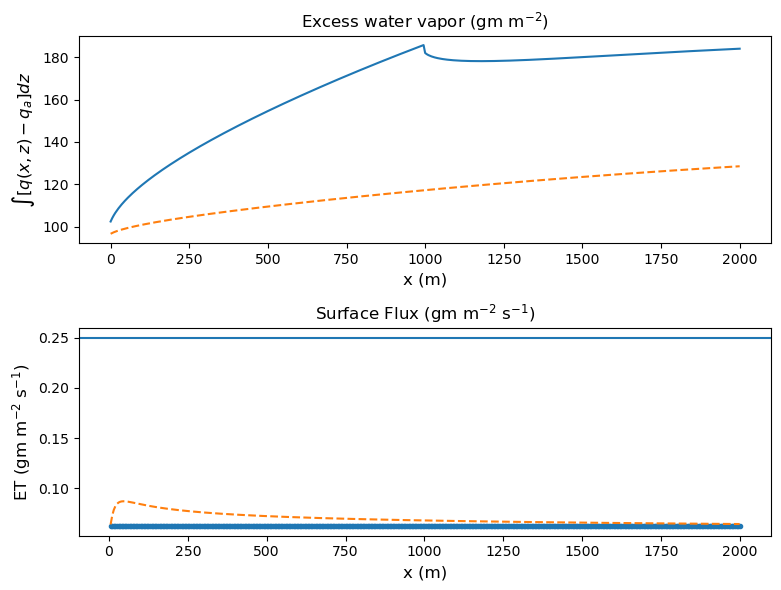

In [19]:
FluxQ_uniform[nx-1, 5]*2260,

(151.30978281994112,)

In [20]:
params['h']*2/3 + 1.4

2.933333333333333

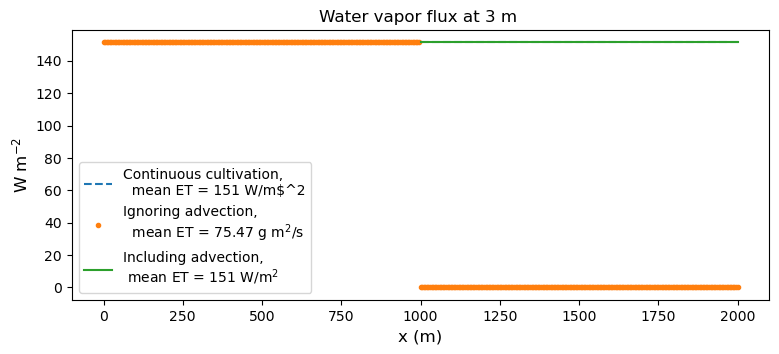

In [21]:
plt.figure(figsize = (9, 3.5))
ax = plt.gca()

ax.plot(x[200:], np.ones(nx )[200:] * FluxQ_uniform[nx-1, 5]*2260, '--',  
         label = "Continuous cultivation, \n  mean ET = {0:.0f} W/m$^2".format(
             FluxQ_uniform[nx-1, 5]*2260))

uniform_flux = FluxQ_uniform[nx-1, 5]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, 5]*(Qs_array == Q_f).mean()
plt.plot(x, FluxQ_uniform[nx-1, 5]*(Qs_array > Q_f)*2260 + 
         FluxQ_fallow[nx-1, 5]*(Qs_array == Q_f)*2260, '.',  
         label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format(uniform_flux*2260))

FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,5]
plt.plot(x[200:], FluxQ[200:, 5]*2260, '-', label = "Including advection,  \n mean ET = {0:.0f} W/m$^2$".format(
    FluxQ[200:, 5].mean()*2260))

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('W m$^{-2}$', fontsize=12, fontweight='normal')
plt.title('Water vapor flux at 3 m ', fontsize=12)
ax.legend()#loc='center left', bbox_to_anchor=(1, 0.5))


In [22]:
(Qs_array > Q_f).mean()

0.49875311720698257

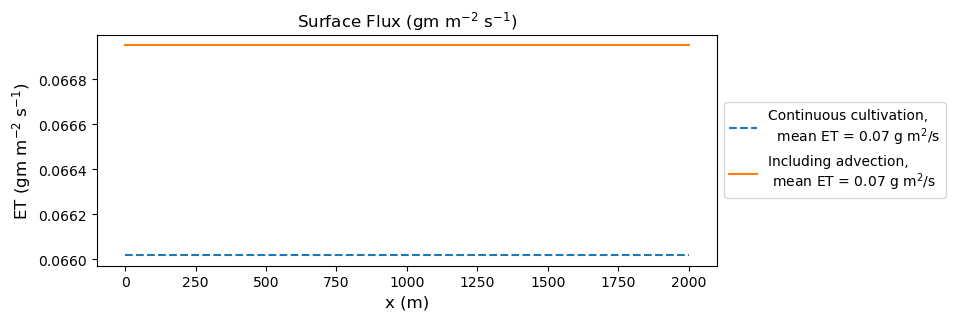

In [23]:
level = 4
plt.figure(figsize = (8, 3))
ax = plt.gca()

plt.plot(x, np.ones(nx ) * FluxQ_uniform[nx-1, level], '--',  
         label = "Continuous cultivation, \n  mean ET = {0:.2f} g m$^2$/s".format(
         FluxQ_uniform[nx-1, level]))

uniform_flux = FluxQ_uniform[nx-1, level]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, level]*(Qs_array == Q_f).mean()
# plt.plot(x, FluxQ_uniform[nx-1, level]*(Qs_array > Q_f) + FluxQ_fallow[nx-1, level]*(Qs_array == Q_f), '.',  \
#          label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format   uniform_flux))

plt.plot(x[:], FluxQ[:, level], '-', 
         label = "Including advection,  \n mean ET = {0:.2f} g m$^2$/s".format(
        FluxQ[:, level].mean()))

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


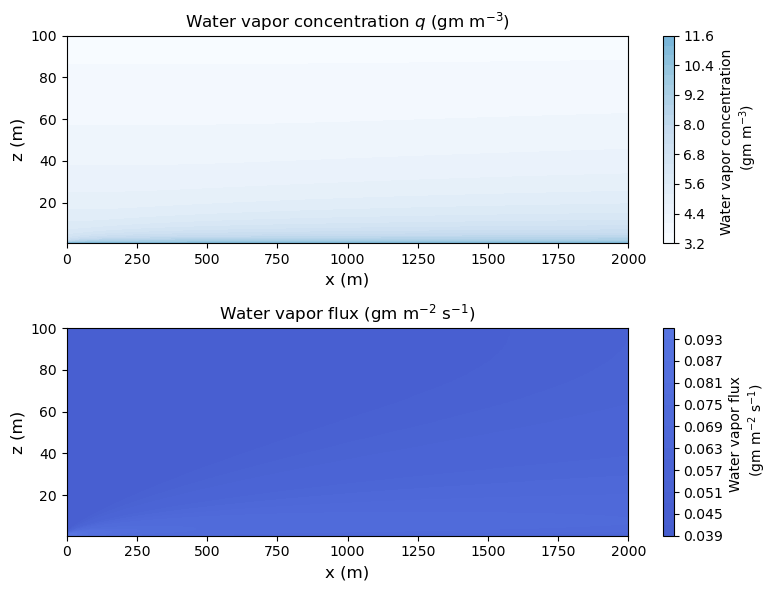

In [24]:
z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q_uniform.T), 25, cmap='Blues',  vmax = Q_c, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x, z, FluxQ_uniform.T.round(4),  20, cmap='coolwarm', vmin = 0, vmax = 1)
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()



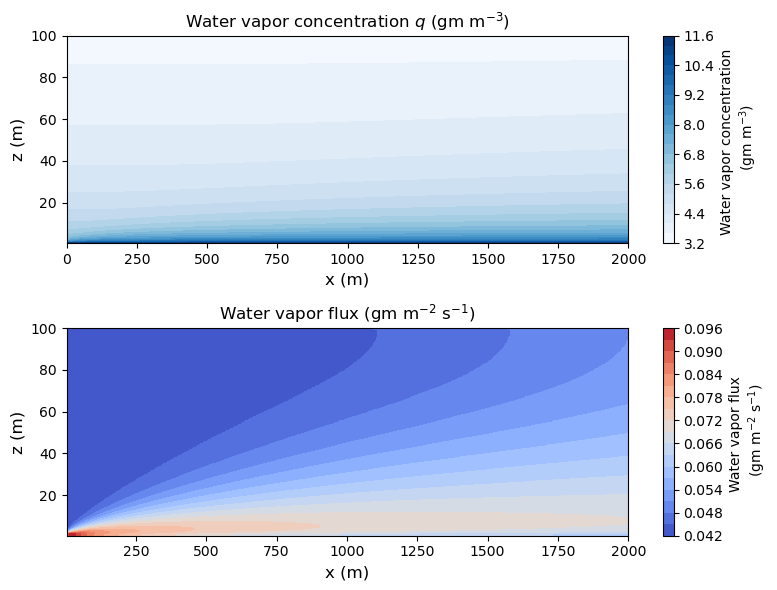

In [25]:


z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q_fallow.T), 25, cmap='Blues',  )#vmax = Q_f, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x[1:], z, FluxQ_fallow[1:].T.round(4),  20, cmap='coolwarm')
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()


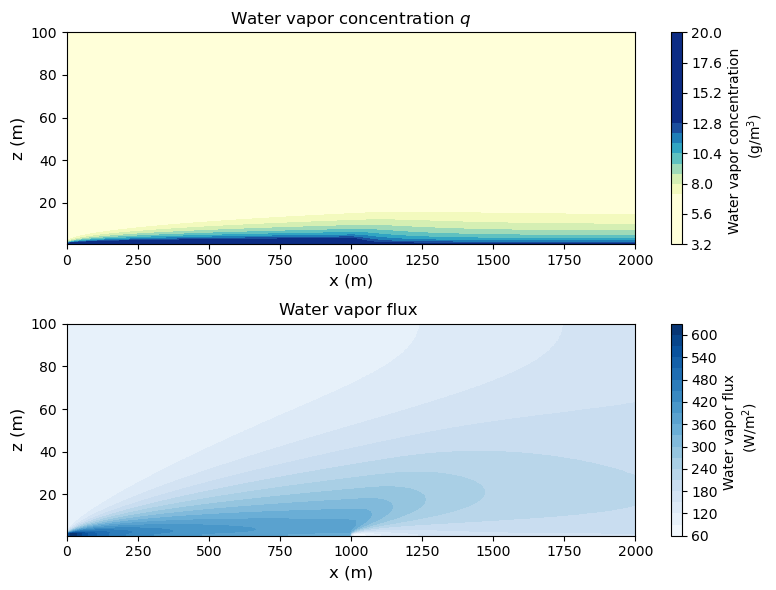

In [26]:
# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

# Normalized concentration (if needed)
# Qd = (Q - Qa) / (Qs - Qa)
blues = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q.T), 25, cmap=custom_cmap,  vmax = 13, vmin = 7)
plt.colorbar(label='Water vapor concentration \n (g/m$^3$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ ', fontsize=12)

plt.subplot(2, 1, 2)

plt.contourf(x, z, FluxQ_neg.T.round(4)*2260,  20, cmap='Blues') #vmin = -0.2, vmax = 0.5)
plt.colorbar(label='Water vapor flux \n (W/m$^2$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux ', fontsize=12)

plt.tight_layout()
plt.show()


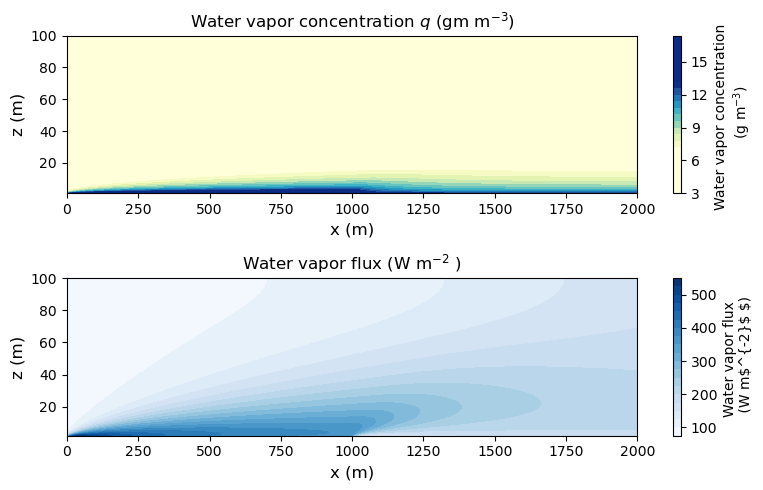

In [27]:
# Reduce the number of tick labels for colorbars
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap
blues = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)

plt.figure(figsize=(8,5))

# Subplot 1: Water vapor concentration
plt.subplot(2, 1, 1)
contour1 = plt.contourf(x, z[1:], Q[:, 1:].T, 25, cmap=custom_cmap, vmax=13, vmin=7)
cbar1 = plt.colorbar(contour1, label='Water vapor concentration \n (g m$^{-3}$)')
cbar1.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Reduce tick labels
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

# Subplot 2: Water vapor flux
plt.subplot(2, 1, 2)
contour2 = plt.contourf(x, z[3:], FluxQ_neg[:, 3:].T.round(4)*2260, 20, cmap='Blues')
cbar2 = plt.colorbar(contour2, label='Water vapor flux \n (W m$^{-2}$ $)')
cbar2.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Reduce tick labels
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (W m$^{-2}$ )', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'y=(Q-Q_a)/(Q_s-Q_a)')

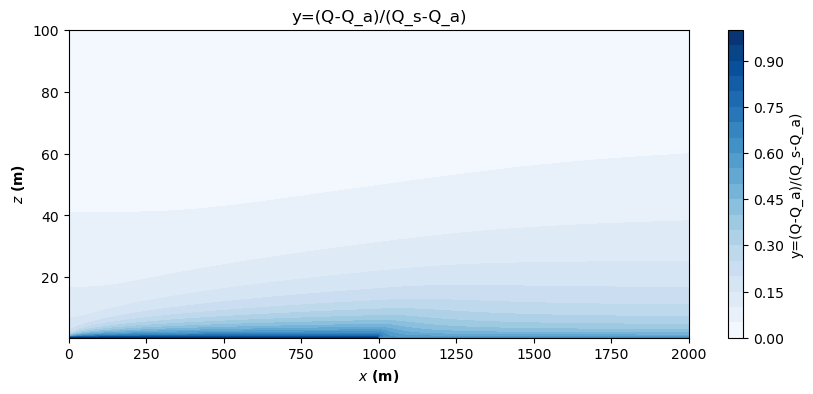

In [28]:

# Normalized concentration
Q_d = (Q - Q_a) / (Q_c - Q_a)

plt.figure(3, figsize = (10,4))
plt.clf()
plt.contourf(x, z, Q_d.T, 20, vmax =1, cmap='Blues')
plt.xlabel(r'$\it{x}$ (m)', fontweight='bold', fontsize=10)
plt.ylabel(r'$\it{z}$ (m)', fontweight='bold', fontsize=10)
plt.colorbar(label='y=(Q-Q_a)/(Q_s-Q_a)')
plt.title('y=(Q-Q_a)/(Q_s-Q_a)')


In [29]:
X, Z = np.meshgrid(x, z)


Text(0.5, 0.92, 'Water Vapor Flux (gm m$^{-2}$ s$^{-1}$)')

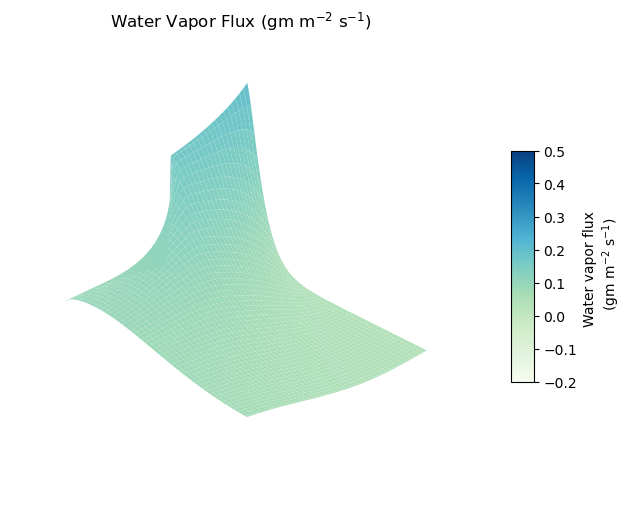

In [30]:
# Create a 3D plot with axes turned off
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X[5:, 50:],Z[5:, 50:], FluxQ_neg.T[5:, 50:], cmap='GnBu', vmin=-0.2, vmax=0.5)

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)', fontsize=10)
ax.view_init(elev=30, azim=45)
# Turn off axes
ax.axis('off')

# Set title
ax.set_title('Water Vapor Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)


## New heading

## Bruetsaert emissivity problems

$  \epsilon_a (T_a) = 1.24 \bigg( \frac{e_{sat}(T_a)\cdot RH/100}{T_a}\bigg)^{1/7}$




In [31]:
params['RH_a'], params['T_a'], e_sat(20)
T_a = 20
RH_a = 10
1.24*(e_sat( T_a)*RH_a/100/ (T_a+273.15))**(1/7)


1.200588261094191

In [32]:
params['Q_a']

3.456695263176665